In [1]:
# Setup (PyTorch, paths, device, seeds)
# %load_ext autoreload
# %autoreload 2

from xray_models import (
    PneumoCNN, eval_one_epoch, fit,
    pick_threshold_youden, evaluate_with_threshold, SAM
)

from xray_helpers import (
    seed_all, compute_pos_weight,
    balance_val_train_split, plot_curves, get_dataloaders, download_xray_dataset
)

import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = int(EPOCHS * 2 / 3)
LR = 1e-4

In [4]:
base_dir, train_dir, val_dir, test_dir = download_xray_dataset()

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Test dir contents: ['PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


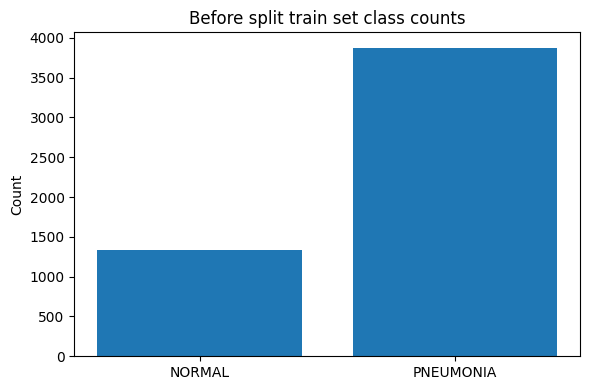

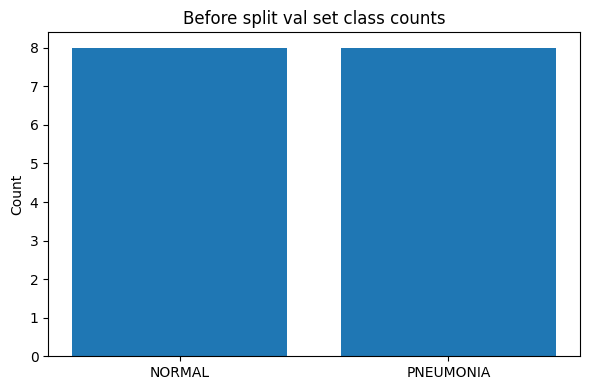

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


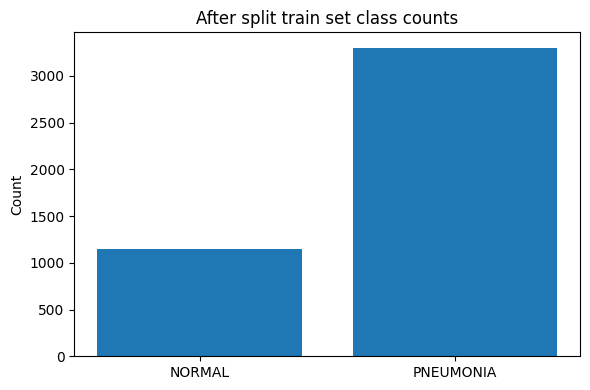

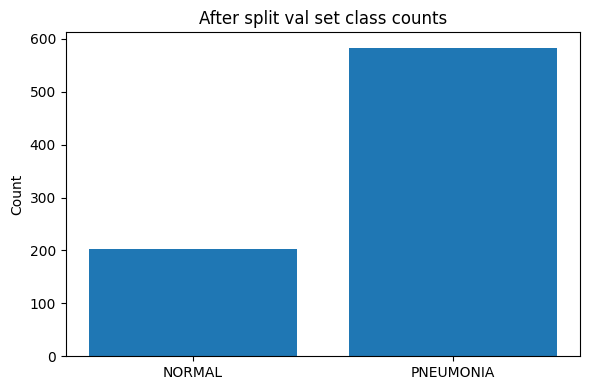

New dir: /tmp/chest_xray_split


In [5]:
new_base = balance_val_train_split(base_dir)
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')

In [6]:
model = PneumoCNN()
model = model.to(device)

data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

print(f"Classes => {data_sets['train_ds'].classes}, , Class indices => {data_sets['train_ds'].class_to_idx}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 234MB/s]


Classes => ['NORMAL', 'PNEUMONIA'], , Class indices => {'NORMAL': 0, 'PNEUMONIA': 1}


Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


[Train] Epoch 1/15:   0%|          | 0/139 [00:00<?, ?it/s]

Input batch shape: torch.Size([32, 3, 224, 224])


[Eval] Epoch 1/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.0827, Accuracy: 0.9339, AUC: 0.9846, PR 0.9943
Val Loss: 0.0230, Accuracy: 0.9860, AUC: 0.9994, PR 0.9998


[Eval] Epoch 2/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0513, Accuracy: 0.9602, AUC: 0.9937, PR 0.9978
Val Loss: 0.0185, Accuracy: 0.9860, AUC: 0.9993, PR 0.9997


[Eval] Epoch 3/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0409, Accuracy: 0.9683, AUC: 0.9961, PR 0.9986
Val Loss: 0.0310, Accuracy: 0.9682, AUC: 0.9988, PR 0.9996


[Eval] Epoch 4/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0369, Accuracy: 0.9750, AUC: 0.9966, PR 0.9988
Val Loss: 0.0362, Accuracy: 0.9783, AUC: 0.9982, PR 0.9994


[Eval] Epoch 5/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0289, Accuracy: 0.9789, AUC: 0.9981, PR 0.9994
Val Loss: 0.0302, Accuracy: 0.9834, AUC: 0.9990, PR 0.9997


[Eval] Epoch 6/15: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.0198, Accuracy: 0.9861, AUC: 0.9992, PR 0.9997
Val Loss: 0.0566, Accuracy: 0.9745, AUC: 0.9984, PR 0.9994


[Eval] Epoch 7/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.0194, Accuracy: 0.9852, AUC: 0.9990, PR 0.9997
Val Loss: 0.0406, Accuracy: 0.9796, AUC: 0.9986, PR 0.9995


[Eval] Epoch 8/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0164, Accuracy: 0.9865, AUC: 0.9994, PR 0.9998
Val Loss: 0.0316, Accuracy: 0.9822, AUC: 0.9990, PR 0.9996


[Eval] Epoch 9/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.0161, Accuracy: 0.9874, AUC: 0.9993, PR 0.9998
Val Loss: 0.0256, Accuracy: 0.9847, AUC: 0.9991, PR 0.9997


[Eval] Epoch 10/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0164, Accuracy: 0.9892, AUC: 0.9992, PR 0.9997
Val Loss: 0.0456, Accuracy: 0.9809, AUC: 0.9988, PR 0.9996


[Eval] Epoch 11/15: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.0117, Accuracy: 0.9924, AUC: 0.9997, PR 0.9999
Val Loss: 0.0502, Accuracy: 0.9796, AUC: 0.9989, PR 0.9996
Early stopping at epoch 11. Best val AUC=0.9994
Training finished in 12.1 min. Best val AUC: 0.9994


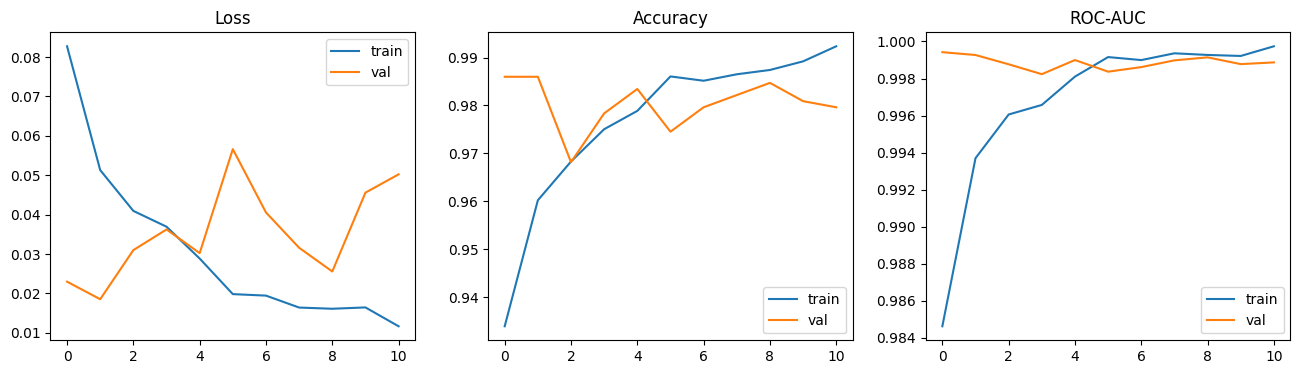

In [7]:
pos_weight = compute_pos_weight(data_sets['train_ds'])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

history, best_val_auc = fit(model, loaders['train_loader'], loaders['val_loader'],
                            criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)

plot_curves(history)

In [8]:
_, _, _, va_auc, va_probs, va_targets = eval_one_epoch(model, loaders['val_loader'], 1, criterion, device, 1)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

[Eval] Epoch 1/1: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]

Chosen threshold: 0.4148593544960022


[Eval] Epoch 1/15: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

probs[:10] = [0.01555901 0.01205908 0.03665642 0.2300371  0.00776572 0.01945855
 0.19259359 0.20542671 0.6101784  0.08713944]
targets[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TEST — loss: 0.4481 | acc@thr: 0.8413 | auc: 0.9604
Specificity: 0.5812 | Sensitivity: 0.9974 | Balanced Acc: 0.7893
PR-AUC from average_precision_score: 0.9700  | PR-AUC from sklearn.metrics: 0.9700
Confusion Matrix :
 [[136  98]
 [  1 389]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9927    0.5812    0.7332       234
   PNEUMONIA     0.7988    0.9974    0.8871       390

    accuracy                         0.8413       624
   macro avg     0.8957    0.7893    0.8101       624
weighted avg     0.8715    0.8413    0.8294       624



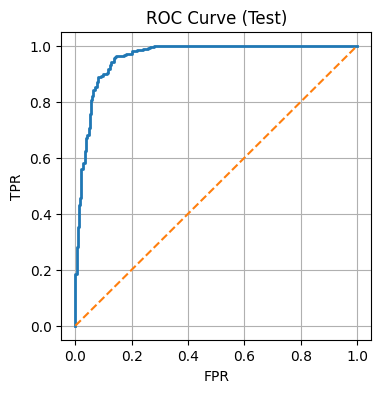

In [9]:
evaluate_with_threshold(model, loaders['test_loader'], criterion, best_thr, device, EPOCHS)